In [1]:
import pandas as pd
# import polars as pl
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.patches import Patch

In [2]:
folder_path = "D:\\ms\\January 2024\\Thesis\\Boiler-Bidding-model\\IECON Format\\"
plt.style.use(folder_path + 'thesis_theme .mplstyle')

output_folder = "D:\\ms\\January 2024\\Thesis\\Files\\Report Plots\\"

In [5]:
folder_path = "D:\\ms\\January 2024\\Thesis\\Boiler-Bidding-model\\Simulation Output\\"

df = pd.read_csv(folder_path + 'recursive_2_to_16_w10_6h_mean_low_demand_with_DA_addl_constr.csv')
# df = pd.read_csv(folder_path + 'recursive_MAY_2_to_16_w30_6h_MA_all_constraints.csv')

df['UTC'] =  pd.to_datetime(df['UTC'])
df['SecondUTC'] =  pd.to_datetime(df['SecondUTC'])

# to fix a logical error in recursive_2_to_16_w10_6h_mean_low_demand_with_DA_addl_constr.csv file
df.loc[(df['UTC'].dt.floor('h') >= pd.Timestamp('2025-03-06 11:00:00')) & (df['UTC'].dt.floor('h') <= pd.Timestamp('2025-03-06 11:15:00')), 'Capacity Bid']= 0
df.loc[df['Capacity Bid'] > 0, 'activation'] = 1
df['direction'] = np.where(
        (df['activation'] == 1) & (df['Bid Up (MW)'] > 0), 1, 
        np.where(
            (df['activation'] == 0) & (df['Bid Down (MW)'] > 0), -1, 
        np.where(
            (df['Bid Up (MW)'] == 0) & (df['Bid Down (MW)'] == 0), 0, np.nan
        )))
df['direction'] = df['direction'].fillna(0)

df['actual_bid_outcome'] = (((df['SpotPriceEUR'] < df['aFRR_UpActivatedPriceEUR_actual']) &(df['activation'] == 1)) |
                                             ((df['aFRR_DownActivatedPriceEUR_actual'] < 0) &(df['activation'] == 0))).astype(int)
energy_agg = df.groupby('UTC')[['Actual Energy Up Cleared (MWh)', 'Actual Energy Down Cleared (MWh)']].sum().rename(
                                                                        columns={'Actual Energy Up Cleared (MWh)': 'Total Energy Up (MWh)',
                                                                                    'Actual Energy Down Cleared (MWh)': 'Total Energy Down (MWh)'})
df = df.merge(energy_agg, on='UTC', how='left')

In [4]:
df_15m = df.drop_duplicates(subset='UTC', keep='first')
df_15m = df_15m[['UTC', 'direction', 'SpotPriceEUR', 'MTU Revenue', 'Total Energy Up (MWh)', 'Total Energy Down (MWh)','Power Boiler (MW)', 'Heat load forecast [MW]','L11 EK plan [MW]']].reset_index(drop = True)

In [7]:
up_eur = df.loc[df['direction'] == 1, 'MTU Revenue'].unique().sum()

up_mwh = df.loc[df['direction'] == 1, 'Actual Energy Up Cleared (MWh)'].sum()

down_eur = df.loc[df['direction'] == -1, 'MTU Revenue'].unique().sum()

down_mwh = df.loc[df['direction'] == -1, 'Actual Energy Down Cleared (MWh)'].sum()

print("Up EUR: ", up_eur)
print("Up MWh: ", up_mwh)
print("Down EUR: ", down_eur)
print("Down MWh: ", down_mwh)
print("Total EUR: ", up_eur + down_eur)

print('output', df['Total Revenue'].unique().sum())

Up EUR:  27735.598593167902
Up MWh:  123.7388033732913
Down EUR:  2746.493923040226
Down MWh:  96.41250290127834
Total EUR:  30482.09251620813
output 1187228.0115871576


In [ ]:
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.01,row_heights=[0.25, 0.25, 0.25, 0.25] )

fig.add_trace(go.Scatter(x=df['SecondUTC'], y=df['System SoE (%)'], mode='lines', name='System SoE (%)'), row=1, col=1)
fig.add_trace(go.Scatter(x=df['SecondUTC'], y=df['Actual System SoE (%)'], mode='lines', name='Actual System SoE (%)'), row=1, col=1)

fig.add_trace(go.Scatter(x=df['SecondUTC'], y=df['Power Boiler (MW)'], mode='lines', name='Power Boiler (MW)'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['SecondUTC'], y=df['L11 EK plan [MW]'], mode='lines', name='L11 EK plan [MW]'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['SecondUTC'], y=df['Capacity Bid'], mode='lines', name='Capacity Bid'), row=2, col=1)
fig.add_trace(go.Scatter(x=df['SecondUTC'], y=df['Heat load forecast [MW]'], mode='lines', name='Heat load forecast [MW]'), row=2, col=1)

fig.add_trace(go.Scatter(x=df['SecondUTC'], y=df['MTU Revenue'], mode='lines', name='Revenue (Eur)'), row=3, col=1)

fig.add_trace(go.Scatter(x=df['SecondUTC'], y=df['Actual Energy Up Cleared (MWh)'], mode='lines', name='Revenue (Eur)'), row=4, col=1)
fig.add_trace(go.Scatter(x=df['SecondUTC'], y=df['Actual Energy Down Cleared (MWh)'], mode='lines', name='Revenue (Eur)'), row=4, col=1)

    # Update layout with size and borders
fig.update_layout(title='Output of OP',xaxis_title='Time', yaxis1_title='System state (%)', yaxis2_title='Bid MW',  yaxis3_title='Revenue (Eur)',   yaxis4_title='Energy (MWh)' ,
legend_title='Legend',template='plotly_white', margin=dict(t=60, b=60, l=60, r=60),  showlegend=True)

# for i in range(1, 5):
#     fig.update_yaxes(showline=True, linewidth=2, linecolor='black', row=i, col=1)
#     fig.update_xaxes(showline=True, linewidth=2, linecolor='black', row=i, col=1)

fig.show()

<>:31: SyntaxWarning: invalid escape sequence '\%'
<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:31: SyntaxWarning: invalid escape sequence '\%'
<>:32: SyntaxWarning: invalid escape sequence '\%'
C:\Users\manis\AppData\Local\Temp\ipykernel_18972\2550700887.py:31: SyntaxWarning: invalid escape sequence '\%'
  ax2.plot(df['SecondUTC'], df['Actual System SoE (%)']*100, label='System State of Energy (\%)', color='royalblue', linewidth=1)
C:\Users\manis\AppData\Local\Temp\ipykernel_18972\2550700887.py:32: SyntaxWarning: invalid escape sequence '\%'
  ax2.set_ylabel('State of Energy (\%)')
C:\Users\manis\AppData\Local\Temp\ipykernel_18972\2550700887.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Total Energy Down (MWh)'] *= -1


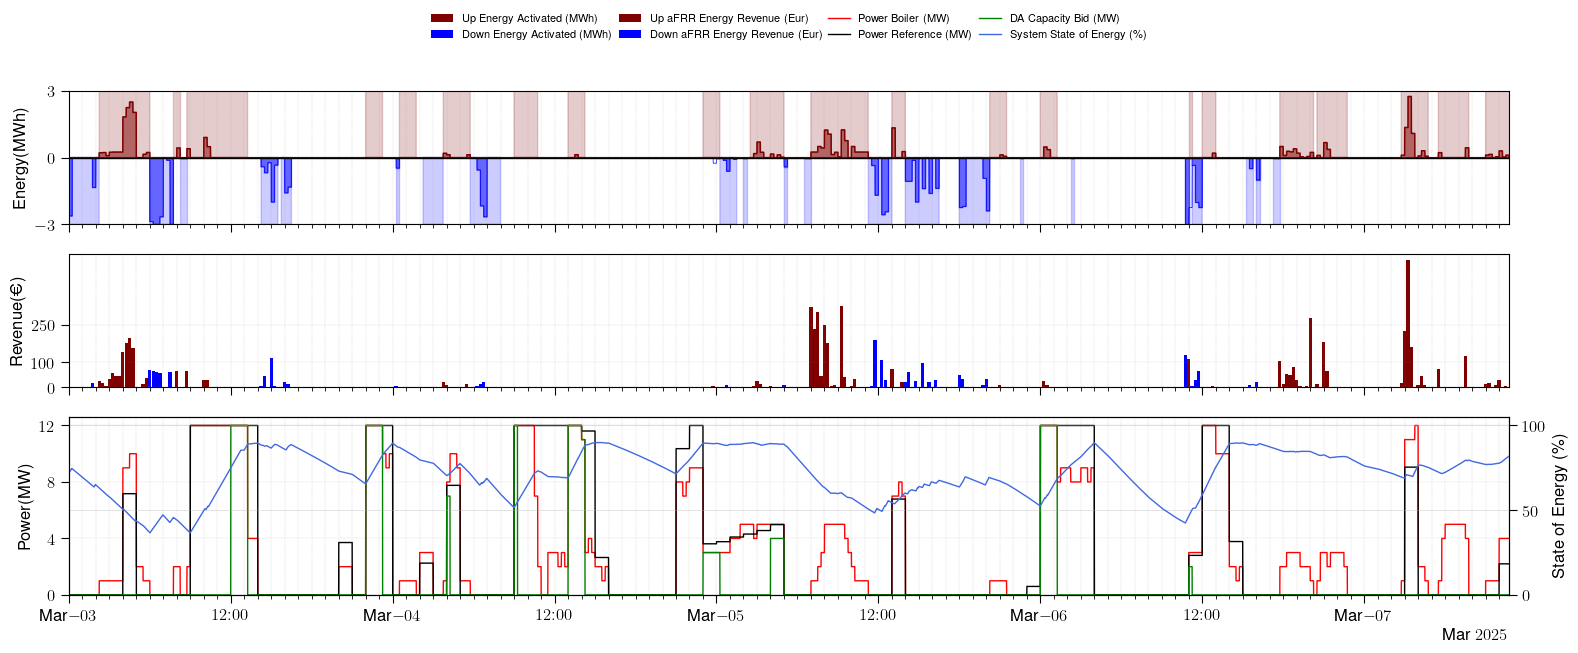

In [6]:
# Final plot of Power, Energy Activation, revenue, SoE
def plot_power_activation(df):
    df = df.loc[(df['UTC'].dt.normalize() >= pd.Timestamp('2025-03-03')) & (df['UTC'].dt.floor('h') <= pd.Timestamp('2025-03-07 10:00:00'))]
    # df = df.iloc[::10, : ]
    df['Total Energy Down (MWh)'] *= -1

    fig, axs = plt.subplots(3, 1, figsize = (16,6), sharex= True, gridspec_kw = {'height_ratios': [1.5, 1.5, 2]})
    colors = np.where(df['direction'] == 1, 'maroon',  np.where(df['direction'] == -1, 'blue', 'lightgray'))

    axs[0].fill_between(df['SecondUTC'], 0, df['direction']*3, where=df['direction'] > 0, color='maroon', alpha=0.2)
    axs[0].fill_between(df['SecondUTC'], 0, df['direction']*3, where=df['direction'] < 0, color='blue', alpha=0.2)
    
    axs[0].fill_between(df['SecondUTC'], 0, df['Total Energy Up (MWh)'], where=df['direction'] > 0, color='maroon', alpha=0.5)
    axs[0].fill_between(df['SecondUTC'], 0, df['Total Energy Down (MWh)'], where=df['direction'] < 0, color='blue', alpha=0.5)

    axs[0].plot(df['SecondUTC'], df['Total Energy Up (MWh)'], linewidth=1, color='maroon')
    axs[0].plot(df['SecondUTC'], df['Total Energy Down (MWh)'], linewidth=0.5, color='blue')
    axs[0].axhline(0, color='black', linewidth=1)
    axs[0].set_ylabel('Energy(MWh)')
 
    # Second plot: Revenue
    axs[1].bar(df['UTC'], df['MTU Revenue'], color = colors, width=0.01) #, edgecolor = 'dimgrey', linewidth = 0.1)
    axs[1].set_ylabel('Revenue(€)')

    # Third plot: line plots
    axs[2].plot(df['SecondUTC'], df['Power Boiler (MW)'], label='Power Boiler (MW)', color='red', linewidth=1)
    axs[2].plot(df['SecondUTC'], df['L11 EK plan [MW]'], label='Power Reference (MW)', linestyle = '-', color='black', linewidth=1)
    axs[2].plot(df['SecondUTC'], df['Capacity Bid'], label='DA Capacity Bid (MW)', linestyle = '-', color='green', linewidth=1)
    axs[2].set_ylabel('Power(MW)')
    ax2 = axs[2].twinx()
    ax2.plot(df['SecondUTC'], df['Actual System SoE (%)']*100, label='System State of Energy (\%)', color='royalblue', linewidth=1)
    ax2.set_ylabel('State of Energy (\%)')

    # align left and right axis with a padding on top
    pad_fraction = 0.05
    left_max = 12 * (1 + pad_fraction)
    right_max = 100 * (1 + pad_fraction)
    axs[2].set_ylim(0, left_max)
    ax2.set_ylim(0, right_max)

    # legend
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    h2, l2 = ax2.get_legend_handles_labels()
    handles.extend(h2)
    labels.extend(l2)

    custom_patches1 = [Patch(facecolor='maroon', label='Up Energy Activated (MWh)'),
                        Patch(facecolor='blue', label='Down Energy Activated (MWh)')]
    custom_patches2 = [Patch(facecolor='maroon', label='Up aFRR Energy Revenue (Eur)'),
                        Patch(facecolor='blue', label='Down aFRR Energy Revenue (Eur)')]
    
    all_handles = custom_patches1 + custom_patches2 + handles

    fig.legend(handles=all_handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1),fancybox=True, frameon=False,  columnspacing=0.5)

    # format ticks and labels
    axs[0].set_yticks([-3, 0,  3])
    axs[1].set_yticks([0, 100,  250])
    axs[2].set_yticks([0, 4, 8, 12])
    ax2.set_yticks([0, 50, 100])
    locator = mdates.HourLocator(byhour=range(0, 24, 12))
    formatter = mdates.ConciseDateFormatter(locator)
    formatter.offset_formats = ['','%Y','%b %Y','%b %Y','%b %Y','%b %Y']
    axs[2].xaxis.set_major_locator(locator)
    axs[2].xaxis.set_minor_locator(mdates.HourLocator())
    axs[2].xaxis.set_major_formatter(formatter)

    axs[0].set_xlim(left=df['UTC'].min(), right=df['UTC'].max())
    axs[1].set_xlim(left=df['UTC'].min(), right=df['UTC'].max())
    axs[2].set_xlim(left=df['UTC'].min(), right=df['UTC'].max())
    axs[0].set_ylim(-3,3)
    # axs[1].set_ylim(0, 250) # limit for revenue
    axs[0].grid(which='both', color='gray', linestyle='--', linewidth=0.2)
    axs[1].grid(which='both', color='gray', linestyle='--', linewidth=0.2)
    axs[2].grid(which='both', color='gray', linestyle='--', linewidth=0.2)

    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
    
    plt.xlabel('UTC Time')
    plt.tight_layout()
    plt.subplots_adjust(hspace = 0.2)
    # plt.savefig(output_folder + 'Simulation.pdf', format='pdf', bbox_inches='tight', dpi=320)
    plt.show()
plt.rcParams.update({
            'figure.dpi': '100' # Default DPI value
    })
plot_power_activation(df)

<>:33: SyntaxWarning: invalid escape sequence '\%'
<>:36: SyntaxWarning: invalid escape sequence '\%'
<>:33: SyntaxWarning: invalid escape sequence '\%'
<>:36: SyntaxWarning: invalid escape sequence '\%'
C:\Users\manis\AppData\Local\Temp\ipykernel_18972\2348300681.py:33: SyntaxWarning: invalid escape sequence '\%'
  axs[3].plot(df['SecondUTC'], df['Actual System SoE (%)']*100, label='System State of Energy (\%)', color='black', linewidth=1)
C:\Users\manis\AppData\Local\Temp\ipykernel_18972\2348300681.py:36: SyntaxWarning: invalid escape sequence '\%'
  axs[3].set_ylabel('State of Energy (\%)')


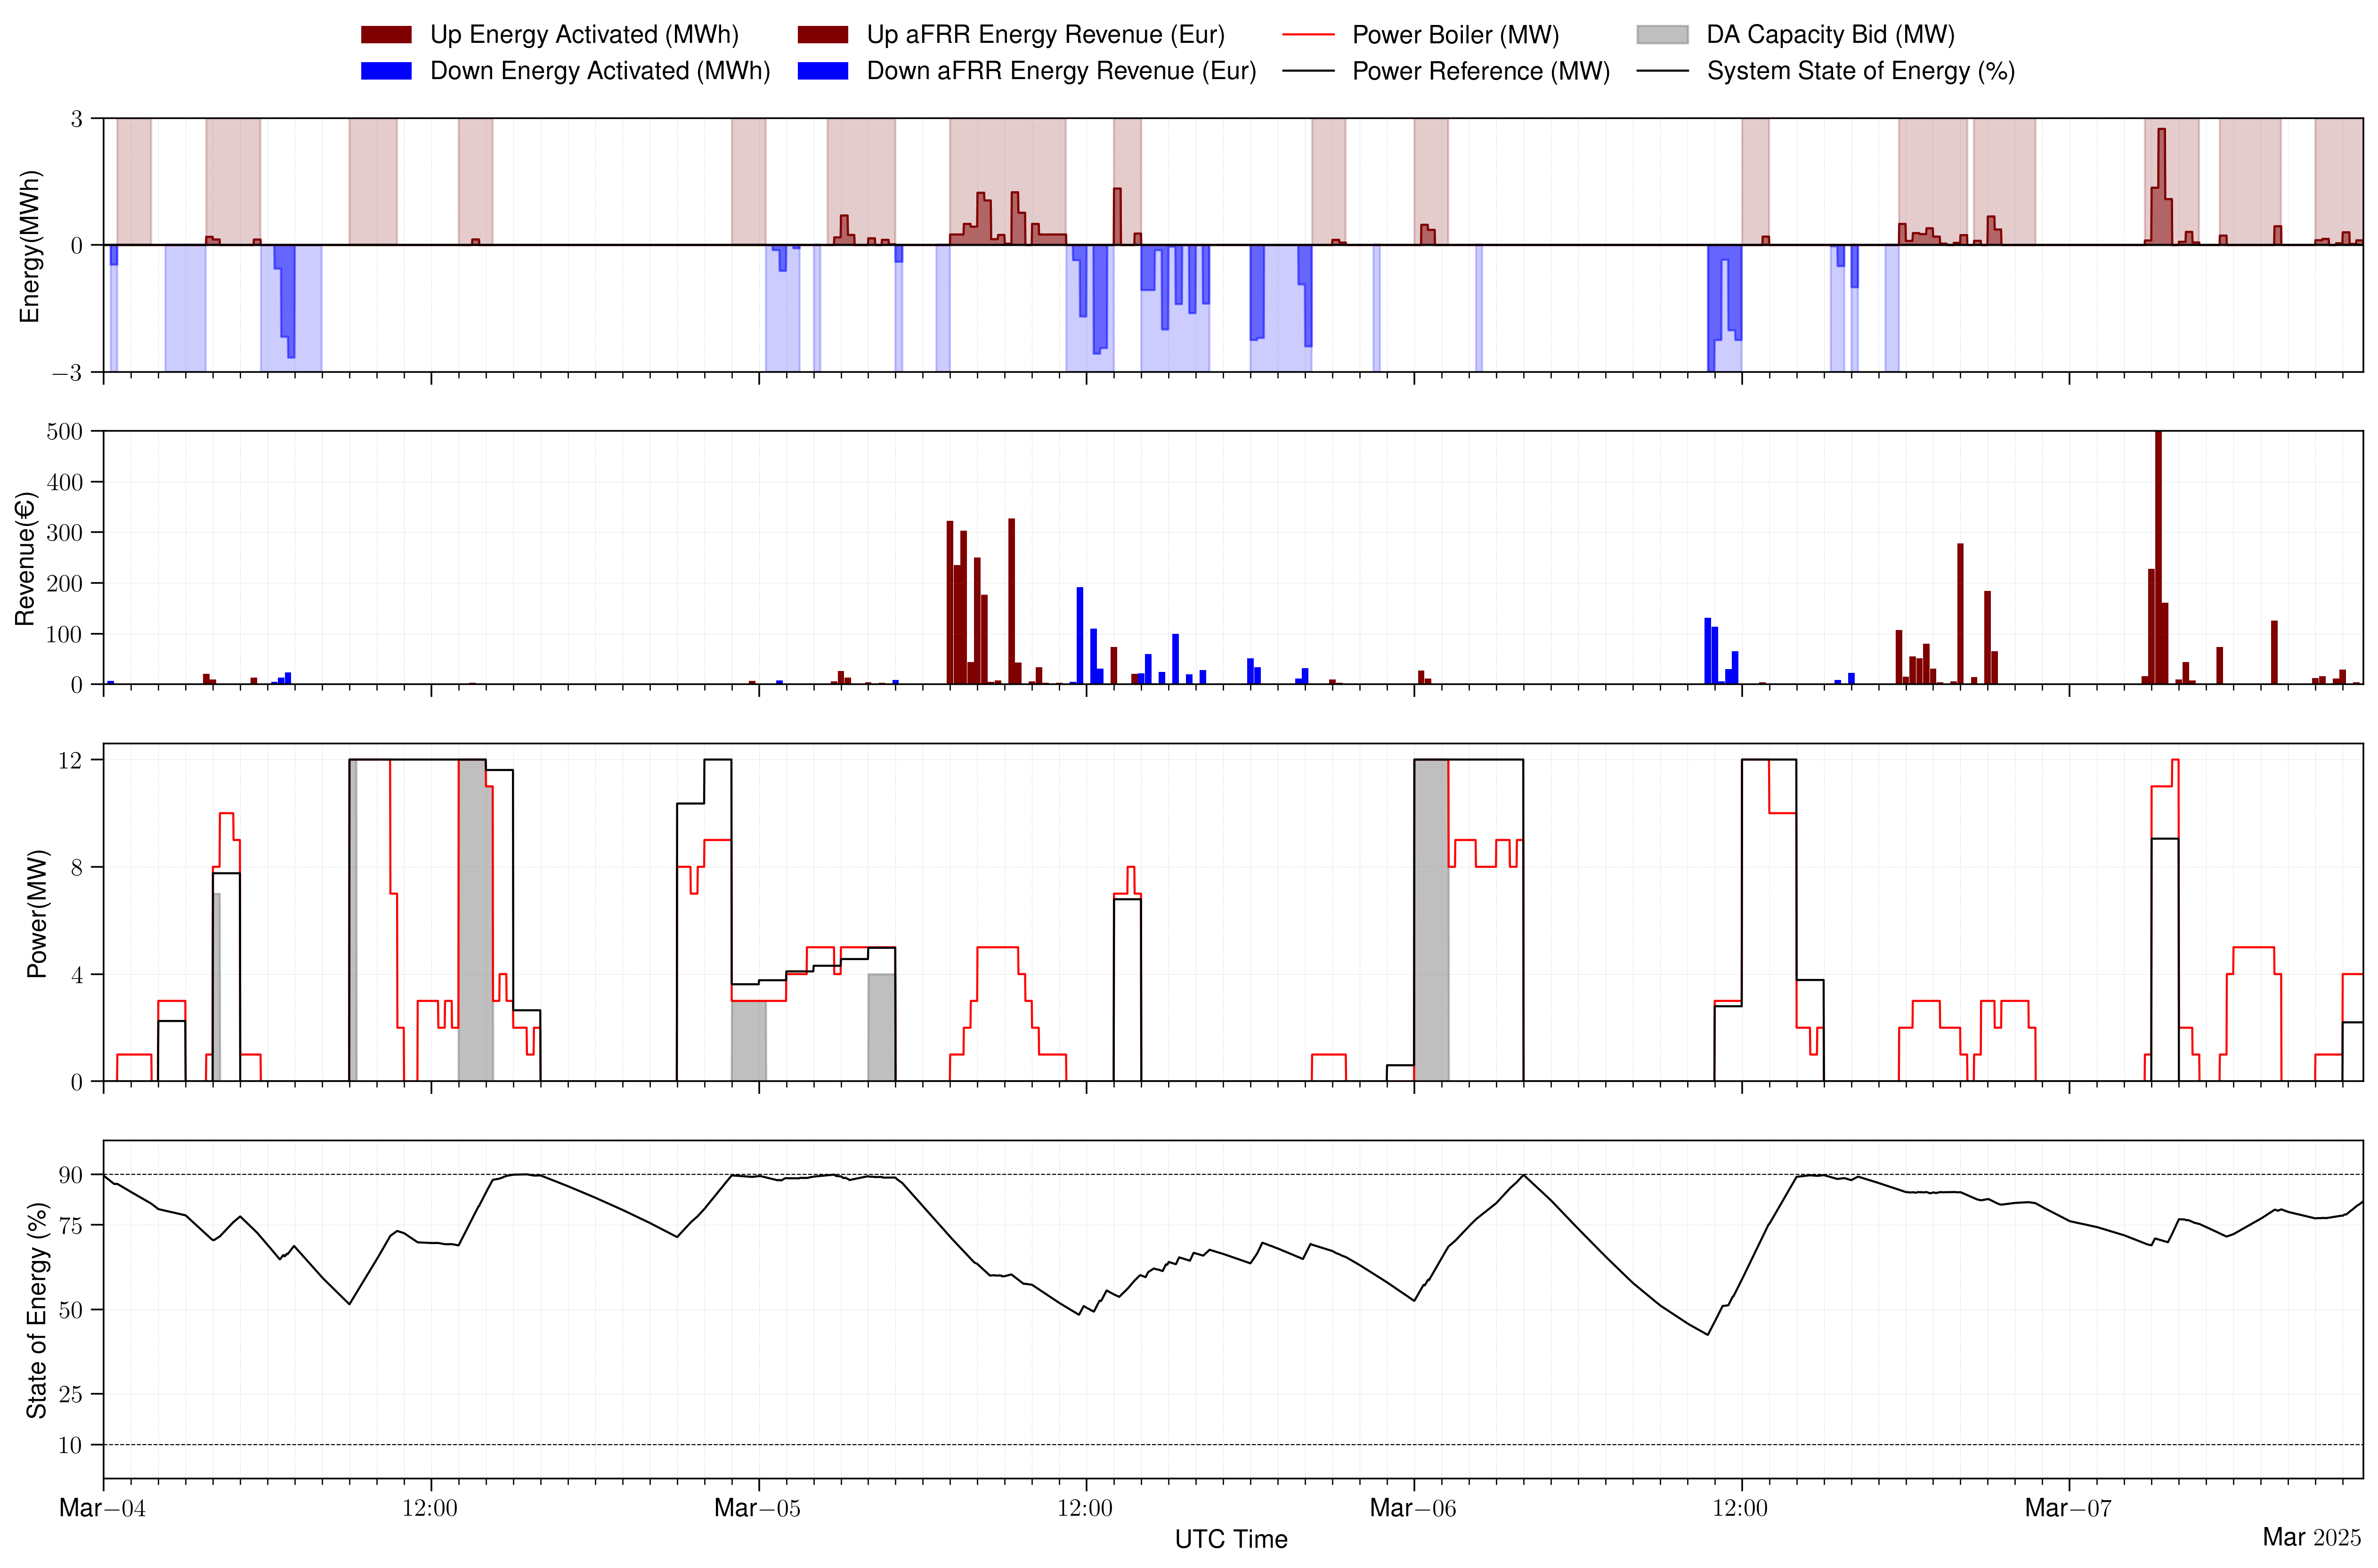

In [17]:
# Final plot of Power, Energy Activation, revenue, SoE
def plot_power_activation(df):
    df = df.loc[(df['UTC'].dt.normalize() >= pd.Timestamp('2025-03-04')) & (df['UTC'].dt.floor('h') <= pd.Timestamp('2025-03-07 11:00:00'))]
    df = df.iloc[::10, : ]
    df['Total Energy Down (MWh)'] *= -1

    fig, axs = plt.subplots(4, 1, figsize = (16,10), sharex= True, gridspec_kw = {'height_ratios': [1.5, 1.5, 2, 2]})
    colors = np.where(df['direction'] == 1, 'maroon',  np.where(df['direction'] == -1, 'blue', 'lightgray'))

    axs[0].fill_between(df['SecondUTC'], 0, df['direction']*3, where=df['direction'] > 0, color='maroon', alpha=0.2)
    axs[0].fill_between(df['SecondUTC'], 0, df['direction']*3, where=df['direction'] < 0, color='blue', alpha=0.2)
    
    axs[0].fill_between(df['SecondUTC'], 0, df['Total Energy Up (MWh)'], where=df['direction'] > 0, color='maroon', alpha=0.5)
    axs[0].fill_between(df['SecondUTC'], 0, df['Total Energy Down (MWh)'], where=df['direction'] < 0, color='blue', alpha=0.5, edgecolor = 'blue')

    axs[0].plot(df['SecondUTC'], df['Total Energy Up (MWh)'], linewidth=1, color='maroon')
    # axs[0].plot(df['SecondUTC'], df['Total Energy Down (MWh)'], linewidth=0.5, color='blue')
    axs[0].axhline(0, color='black', linewidth=1)
    axs[0].set_ylabel('Energy(MWh)')
 
    # Second plot: Revenue
    axs[1].bar(df['UTC'], df['MTU Revenue'], color = colors, width=0.01) #, edgecolor = 'dimgrey', linewidth = 0.1)
    axs[1].set_ylabel('Revenue(€)')

    # Third plot: line plots
    axs[2].plot(df['SecondUTC'], df['Power Boiler (MW)'], label='Power Boiler (MW)', color='red', linewidth=1)
    axs[2].plot(df['SecondUTC'], df['L11 EK plan [MW]'], label='Power Reference (MW)', linestyle = '-', color='black', linewidth=1)
    # axs[2].plot(df['SecondUTC'], df['Capacity Bid'], label='DA Capacity Bid (MW)', linestyle = '--', color='green', linewidth=2)
    axs[2].fill_between(df['SecondUTC'], df['Capacity Bid'], label='DA Capacity Bid (MW)', linestyle = '-', color='grey', alpha = 0.5)
    axs[2].set_ylabel('Power(MW)')

    #Fourth plot: SoE
    axs[3].plot(df['SecondUTC'], df['Actual System SoE (%)']*100, label='System State of Energy (\%)', color='black', linewidth=1)
    axs[3].axhline(10, color='black', linewidth=0.5, linestyle = '--')
    axs[3].axhline(90, color='black', linewidth=0.5, linestyle = '--')
    axs[3].set_ylabel('State of Energy (\%)')

    # align left and right axis with a padding on top
    # pad_fraction = 0.05
    # left_max = 12 * (1 + pad_fraction)
    # right_max = 100 * (1 + pad_fraction)
    # axs[2].set_ylim(0, left_max)

    # legend
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    custom_patches1 = [Patch(facecolor='maroon', label='Up Energy Activated (MWh)'),
                        Patch(facecolor='blue', label='Down Energy Activated (MWh)')]
    custom_patches2 = [Patch(facecolor='maroon', label='Up aFRR Energy Revenue (Eur)'),
                        Patch(facecolor='blue', label='Down aFRR Energy Revenue (Eur)')]
    
    all_handles = custom_patches1 + custom_patches2 + handles

    fig.legend(handles=all_handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05),fancybox=True, frameon=False,  columnspacing=1, fontsize = 12)

    # format ticks and labels
    axs[0].set_yticks([-3, 0,  3])
    # axs[1].set_yticks([0, 100,  250])
    axs[2].set_yticks([0, 4, 8, 12])
    axs[3].set_yticks([10, 25, 50, 75, 90])
    locator = mdates.HourLocator(byhour=range(0, 24, 12))
    formatter = mdates.ConciseDateFormatter(locator)
    formatter.offset_formats = ['','%Y','%b %Y','%b %Y','%b %Y','%b %Y']
    axs[2].xaxis.set_major_locator(locator)
    axs[2].xaxis.set_minor_locator(mdates.HourLocator())
    axs[2].xaxis.set_major_formatter(formatter)

    axs[0].set_xlim(left=df['UTC'].min(), right=df['UTC'].max())
    axs[1].set_xlim(left=df['UTC'].min(), right=df['UTC'].max())
    axs[2].set_xlim(left=df['UTC'].min(), right=df['UTC'].max())
    axs[0].set_ylim(-3,3)
    axs[1].set_ylim(0, 500) # limit for revenue
    axs[2].set_ylim(0)
    axs[3].set_ylim(0, 100)
    axs[0].grid(which='both', color='gray', linestyle='--', linewidth=0.2, alpha = 0.3)
    axs[1].grid(which='both', color='gray', linestyle='--', linewidth=0.2, alpha = 0.3)
    axs[2].grid(which='both', color='gray', linestyle='--', linewidth=0.2, alpha = 0.3)
    axs[3].grid(which='both', color='gray', linestyle='--', linewidth=0.2, alpha = 0.3)

    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
    
    plt.xlabel('UTC Time')
    plt.tight_layout()
    plt.subplots_adjust(hspace = 0.2)
    plt.savefig(output_folder + 'simulation_March_MA_prices_W10.pdf', format='pdf', bbox_inches='tight', dpi=320)
    plt.show()

# plt.rcParams.update({
#             'figure.dpi': '320' # Default DPI value
#     })
plot_power_activation(df)

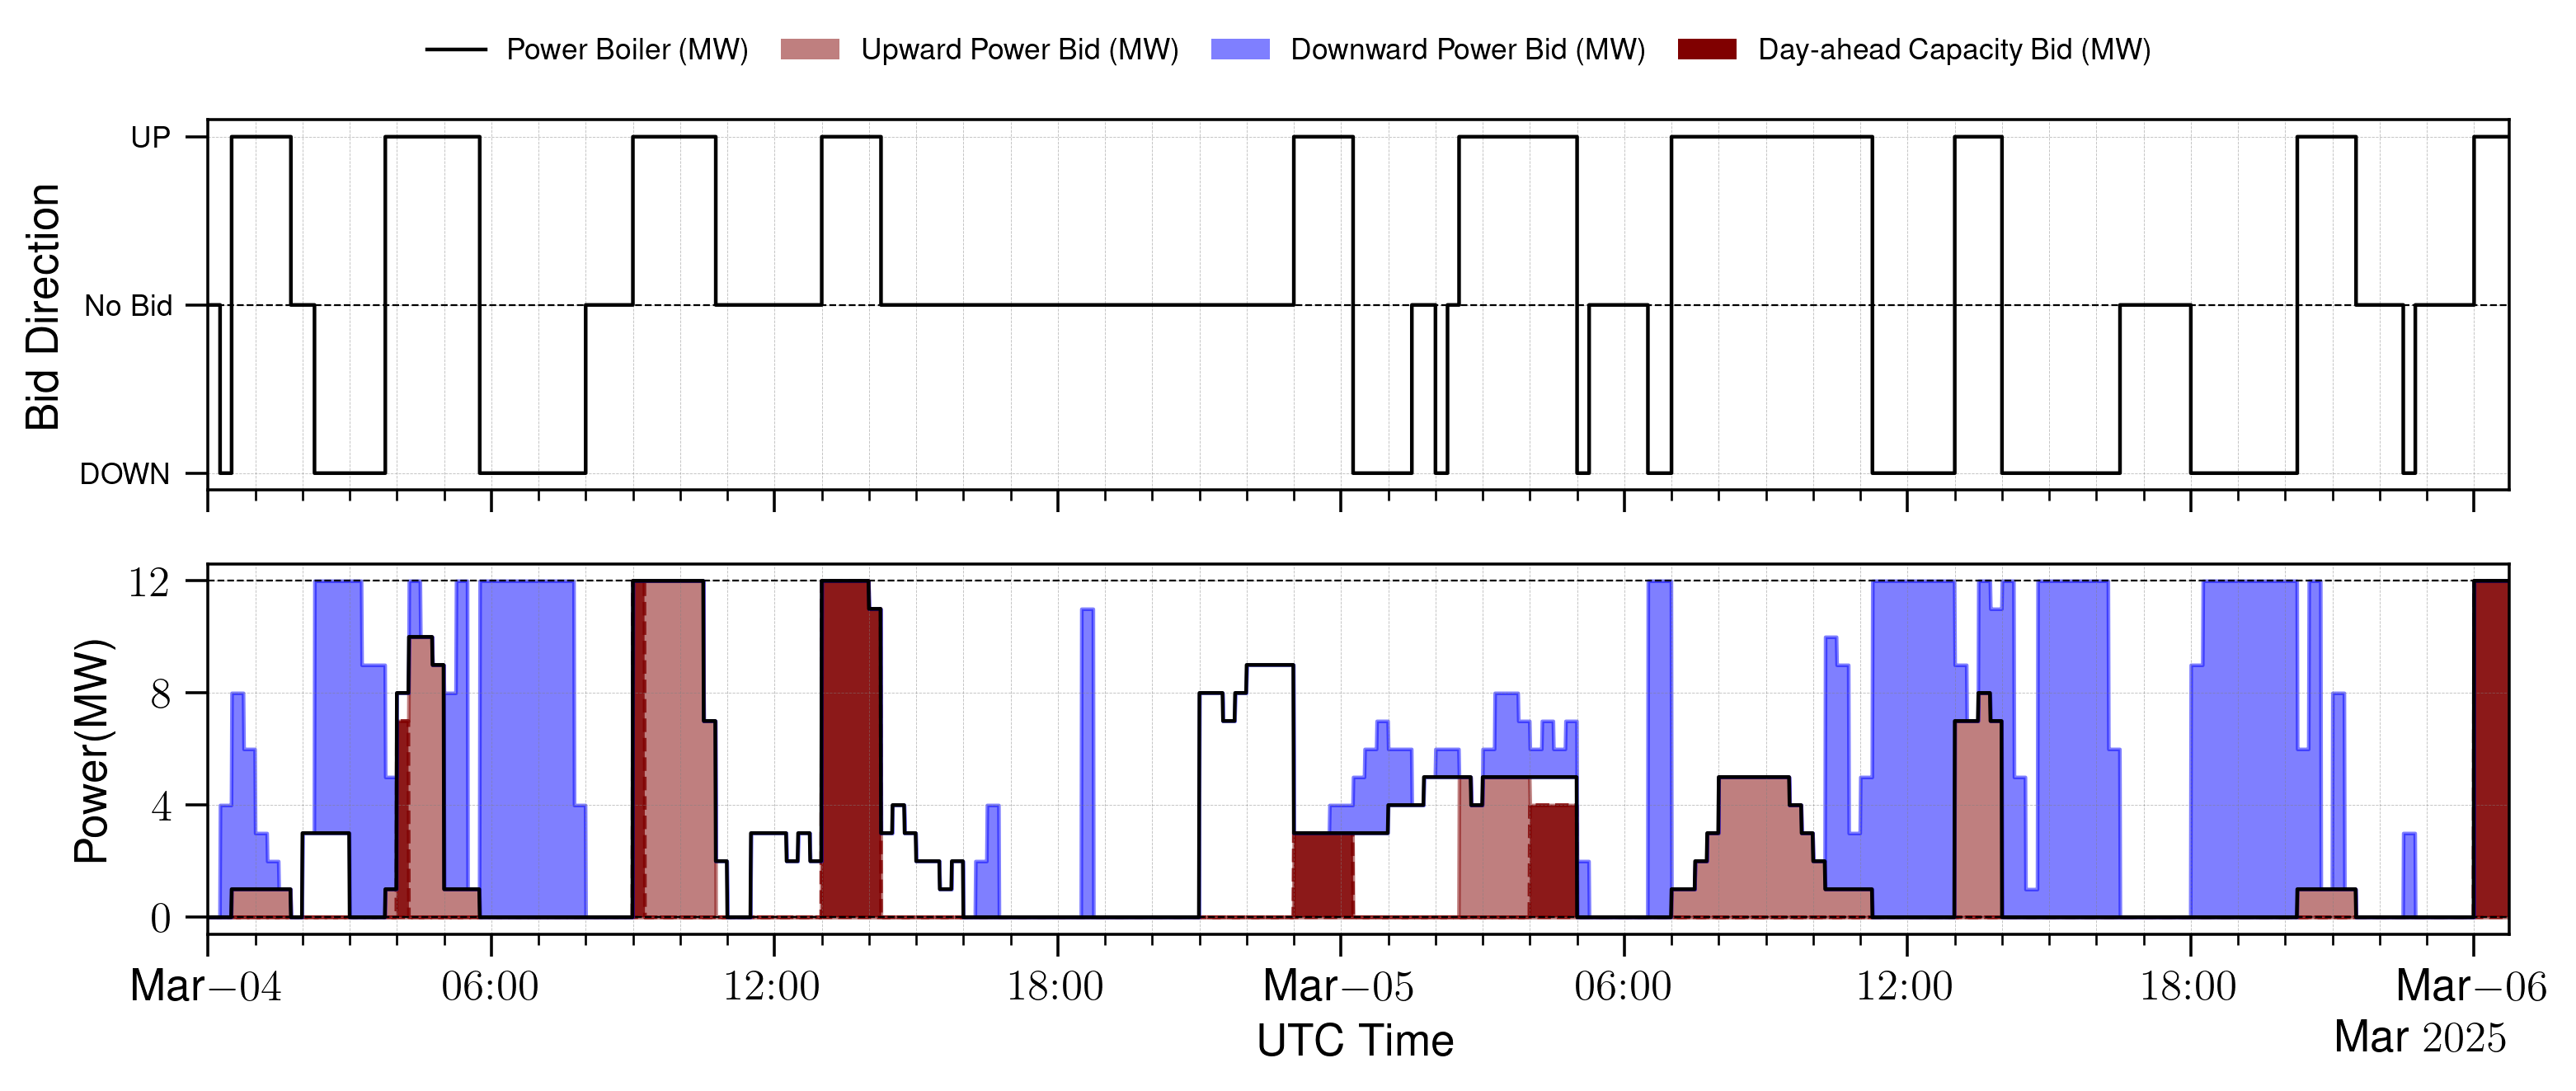

In [19]:
# Final plot of Power, Energy Activation, revenue, SoE
def plot_bid_attributes(df):
    df = df.loc[(df['UTC'].dt.normalize() >= pd.Timestamp('2025-03-04')) & (df['UTC'].dt.floor('h') <= pd.Timestamp('2025-03-06 00:00:00'))]
    df = df.iloc[::10, : ]
    df['Total Energy Down (MWh)'] *= -1

    fig, axs = plt.subplots(2, 1, figsize = (10,4), sharex= True, gridspec_kw = {'height_ratios': [2, 2]})
    colors = np.where(df['direction'] == 1, 'maroon',  np.where(df['direction'] == -1, 'blue', 'lightgray'))
    # axs[0].fill_between(df['SecondUTC'], 0, df['direction'], where=df['direction'] > 0, color='maroon', alpha=0.2)
    # axs[0].fill_between(df['SecondUTC'], 0, df['direction'], where=df['direction'] < 0, color='blue', alpha=0.2)
    axs[0].step(df['SecondUTC'], df['direction'], where='post', color='black', linewidth=1)

    # axs[0].plot(df['SecondUTC'], df['System SoE (%)'], label='System State of Energy (\%)', color='black', linewidth=1)

    axs[0].axhline(0, color='black', linewidth=0.5, linestyle = '--')
    axs[0].set_ylabel('Bid Direction')

    # Second plot: line plots
    P_down = df['Power Boiler (MW)'] + df['Bid Down (MW)']

    axs[1].plot(df['SecondUTC'], df['Power Boiler (MW)'], label='Power Boiler (MW)', color='black', linewidth=1)
    # axs[1].fill_between(df['SecondUTC'], 0, df['Bid Up (MW)'], where=df['direction'] > 0, color='maroon', alpha=0.5)
    # axs[1].fill_between(df['SecondUTC'], df['Power Boiler (MW)'], P_down, where = df['direction'] < 0, color='blue', alpha=0.5)
    axs[1].fill_between(df['SecondUTC'], df['Capacity Bid'], linestyle = '--', color='maroon', alpha = 0.8)

    axs[1].fill_between(df['SecondUTC'], 0, df['Bid Up (MW)'], color='maroon', alpha=0.5)
    axs[1].fill_between(df['SecondUTC'], df['Power Boiler (MW)'], P_down, color='blue', alpha=0.5)
    axs[1].axhline(0, color='black', linewidth=0.5, linestyle = '--')
    axs[1].axhline(12, color='black', linewidth=0.5, linestyle = '--')
    axs[1].set_ylabel('Power(MW)')

    # legend
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    custom_patches1 = [Patch(facecolor='maroon', alpha =0.5, label='Upward Power Bid (MW)'),
                        Patch(facecolor='blue', alpha =0.5, label='Downward Power Bid (MW)'),
                        Patch(facecolor='maroon', label='Day-ahead Capacity Bid (MW)')]
    
    all_handles = handles + custom_patches1

    fig.legend(handles=all_handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05),fancybox=True, frameon=False,  columnspacing=1)

    # format ticks and labels
    axs[0].set_yticks([-1, 0, 1])
    axs[0].set_yticklabels(['DOWN', 'No Bid', 'UP'], fontsize = 8)
    axs[1].set_yticks([0, 4, 8, 12])
    # axs[3].set_yticks([10, 25, 50, 75, 90])
    locator = mdates.HourLocator(byhour=range(0, 24, 6))
    formatter = mdates.ConciseDateFormatter(locator)
    formatter.offset_formats = ['','%Y','%b %Y','%b %Y','%b %Y','%b %Y']
    axs[1].xaxis.set_major_locator(locator)
    axs[1].xaxis.set_minor_locator(mdates.HourLocator())
    axs[1].xaxis.set_major_formatter(formatter)

    axs[0].set_xlim(left=df['UTC'].min(), right=df['UTC'].max())
    axs[1].set_xlim(left=df['UTC'].min(), right=df['UTC'].max())
    # axs[2].set_xlim(left=df['UTC'].min(), right=df['UTC'].max())
    # axs[0].set_ylim(-1,1)
    # axs[1].set_ylim(0, 500) # limit for revenue
    # axs[2].set_ylim(0)
    # axs[3].set_ylim(0, 100)
    axs[0].grid(which='both', color='gray', linestyle='--', linewidth=0.2)
    axs[1].grid(which='both', color='gray', linestyle='--', linewidth=0.2)

    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
    
    plt.xlabel('UTC Time')
    plt.tight_layout()
    plt.subplots_adjust(hspace = 0.2)
    plt.savefig(output_folder + 'bid_attribute_MA_march_4to6.pdf', format='pdf', bbox_inches='tight', dpi=320)
    plt.show()
# plt.rcParams.update({
#             'figure.dpi': '320' # Default DPI value
#     })
plot_bid_attributes(df)

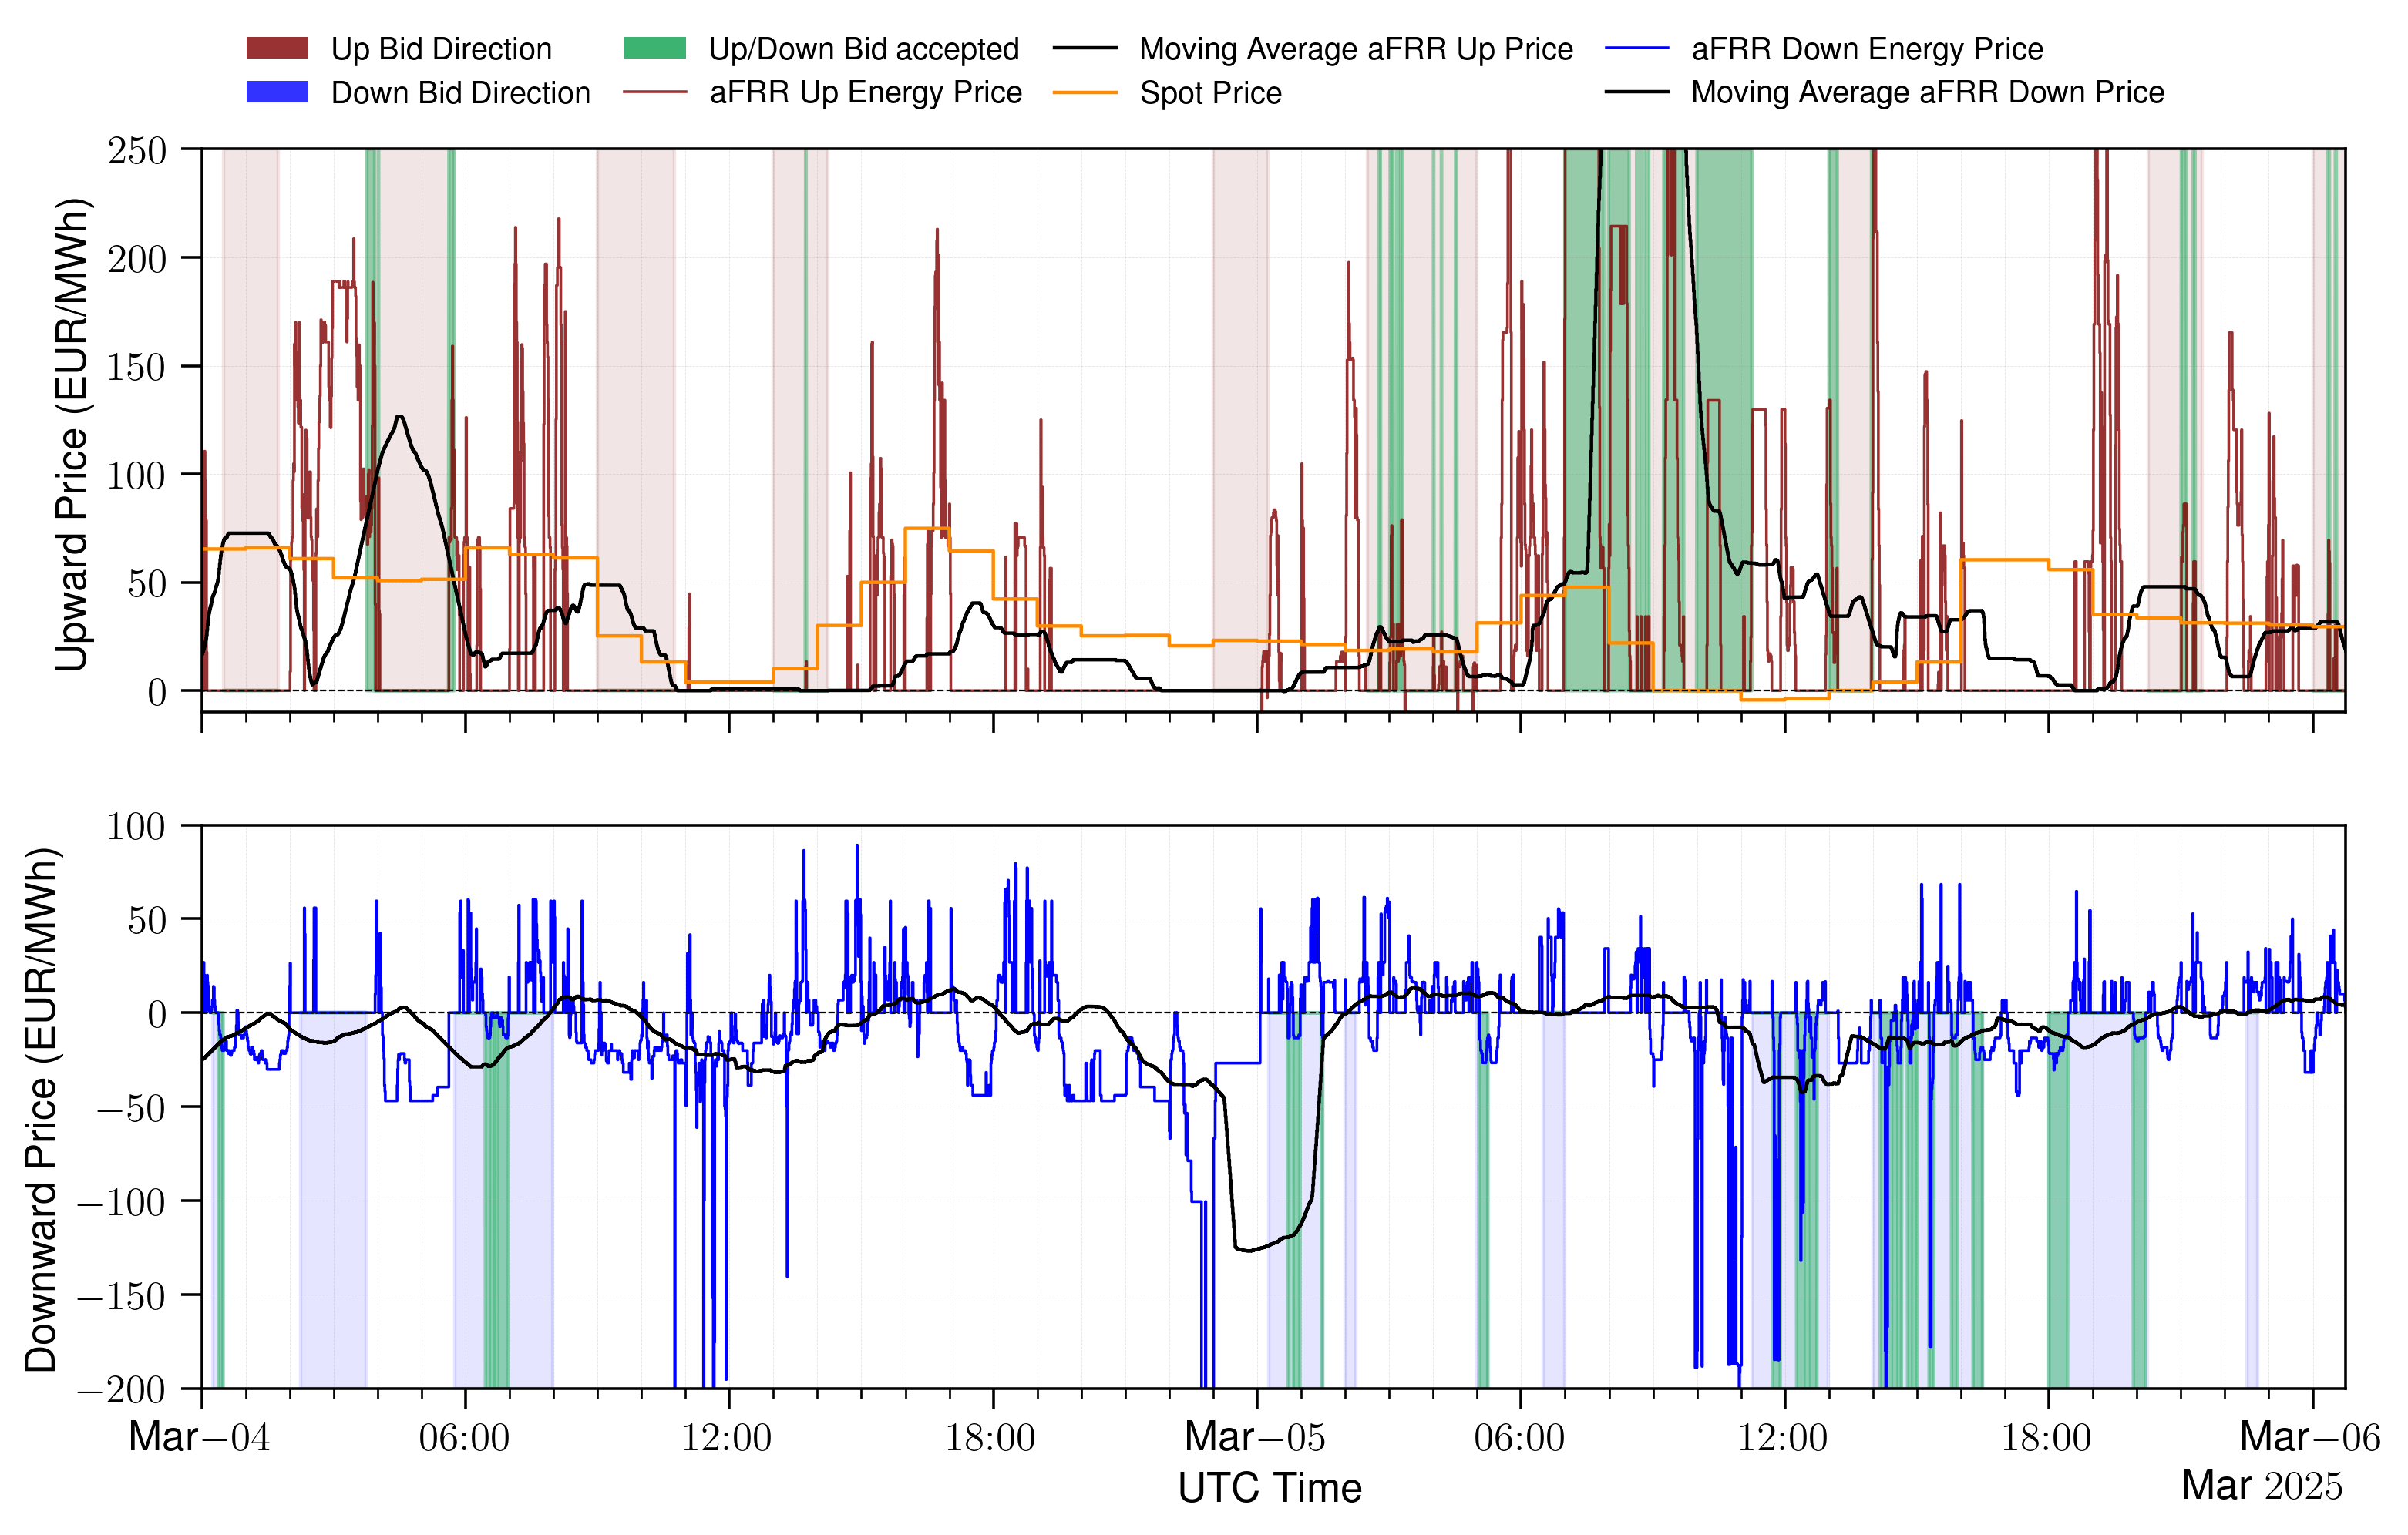

In [36]:
# Final plot of Power, Energy Activation, revenue, SoE
def plot_bid_attributes(df):
    df = df.loc[(df['UTC'].dt.normalize() >= pd.Timestamp('2025-03-04')) & (df['UTC'].dt.floor('h') <= pd.Timestamp('2025-03-06 00:00:00'))]
    df = df.iloc[::10, : ]
    df['Total Energy Down (MWh)'] *= -1

    fig, axs = plt.subplots(2, 1, figsize = (10,6), sharex= True, gridspec_kw = {'height_ratios': [2, 2]})
    colors = np.where(df['direction'] == 1, 'maroon',  np.where(df['direction'] == -1, 'blue', 'lightgray'))

    # first plot: Up price
    axs[0].fill_between(df['SecondUTC'], 0, df['direction']*250, where=df['direction'] > 0, color="maroon", alpha = 0.1)
    axs[0].fill_between(df['SecondUTC'], 0, df['actual_bid_outcome']*250, where=df['direction'] > 0, color='mediumseagreen', alpha=0.5)

    axs[0].step(df['SecondUTC'], df['aFRR_UpActivatedPriceEUR_actual'], where='post', color='maroon', linewidth=0.8, alpha = 0.8, label='aFRR Up Energy Price')
    axs[0].step(df['SecondUTC'], df['aFRR_UpActivatedPriceEUR'], where='post', color='black', linewidth=1, label='Moving Average aFRR Up Price')
    axs[0].step(df['SecondUTC'], df['SpotPriceEUR'], where='post', color="darkorange", linewidth=1, label='Spot Price')
    axs[0].axhline(0, color='black', linewidth=0.5, linestyle = '--')
    axs[0].set_ylabel('Upward Price (EUR/MWh)')

    # Second plot: Down Price
    axs[1].fill_between(df['SecondUTC'], 0, df['direction']*200, where=df['direction'] < 0, color="blue", alpha = 0.1)
    axs[1].fill_between(df['SecondUTC'], 0, -df['actual_bid_outcome']*250, where=df['direction'] < 0, color="#31b66b", alpha=0.5)

    axs[1].step(df['SecondUTC'], df['aFRR_DownActivatedPriceEUR_actual'], where='post', color='blue', linewidth=0.8, label='aFRR Down Energy Price')
    axs[1].step(df['SecondUTC'], df['aFRR_DownActivatedPriceEUR'], where='post', color='black', linewidth=1, label='Moving Average aFRR Down Price')
    axs[1].axhline(0, color='black', linewidth=0.5, linestyle = '--')
    axs[1].set_ylabel('Downward Price (EUR/MWh)')

    # legend
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)

    custom_patches1 = [Patch(facecolor='maroon', alpha = 0.8, label='Up Bid Direction'),
                        Patch(facecolor='blue', alpha = 0.8, label='Down Bid Direction'),
                        Patch(facecolor='mediumseagreen', label='Up/Down Bid accepted')]
    
    all_handles = custom_patches1 + handles

    fig.legend(handles=all_handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.05),fancybox=True, frameon=False,  columnspacing=1, fontsize = 9)

    # format ticks and labels
    locator = mdates.HourLocator(byhour=range(0, 24, 6))
    formatter = mdates.ConciseDateFormatter(locator)
    formatter.offset_formats = ['','%Y','%b %Y','%b %Y','%b %Y','%b %Y']
    axs[1].xaxis.set_major_locator(locator)
    axs[1].xaxis.set_minor_locator(mdates.HourLocator())
    axs[1].xaxis.set_major_formatter(formatter)
    axs[1].set_ylim(-200,100)
    axs[0].set_ylim(-10, 250) # limit for revenue
    axs[0].set_xlim(left=df['UTC'].min(), right=df['UTC'].max())
    axs[1].set_xlim(left=df['UTC'].min(), right=df['UTC'].max())
    axs[0].grid(which='both', color='gray', linestyle='--', linewidth=0.2, alpha = 0.2)
    axs[1].grid(which='both', color='gray', linestyle='--', linewidth=0.2, alpha = 0.2)

    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
    
    plt.xlabel('UTC Time')
    plt.tight_layout()
    plt.subplots_adjust(hspace = 0.2)
    plt.savefig(output_folder + 'actual_vs_MA_prices.pdf', format='pdf', bbox_inches='tight', dpi=320)
    plt.show()
# plt.rcParams.update({
#             'figure.dpi': '320' # Default DPI value
#     })
plot_bid_attributes(df)

Total cost: 68966.22 EUR
Total effective cost: 43305.52 EUR
Absolute drop in cost: 25660.69 EUR
Relative drop in cost: 37.21%


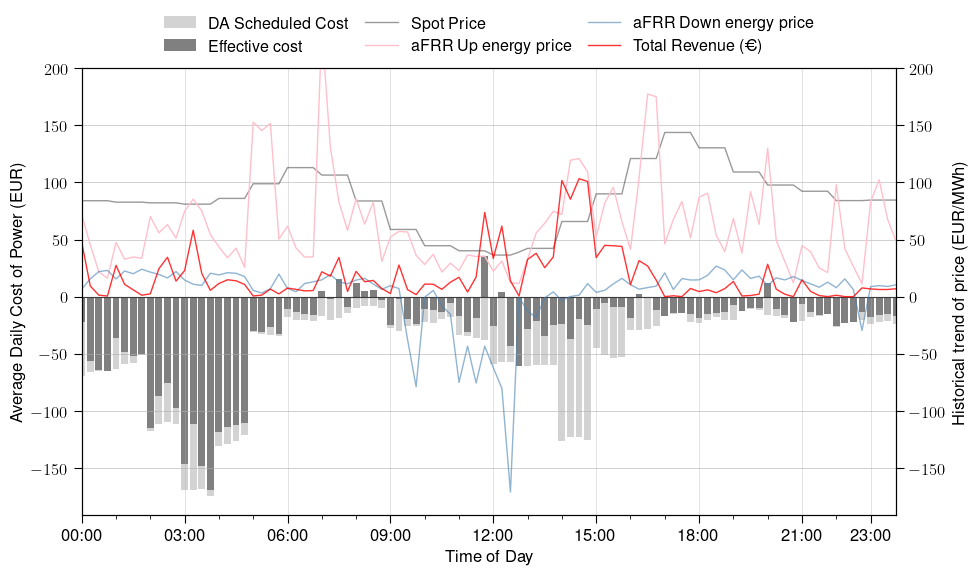

In [ ]:
def plot_revenue_spotprice_mean(df, afrr):
    df = df.copy()
    df['MTU Revenue'] = df['MTU Revenue'].clip(upper=500)
    df['Up Revenue'] = df['MTU Revenue'].where(df['direction'] == 1, 0)
    df['Down Revenue'] = df['MTU Revenue'].where(df['direction'] == -1, 0)
    df['Cost'] = df['SpotPriceEUR'] * df['Power Boiler (MW)'] * 0.25
    df['eff cost'] = df['Cost'] - df['Up Revenue'] - df['Down Revenue']
    df['Time'] = df['UTC'].dt.strftime('%H:%M')

    mean_profile = df.groupby('Time')[['MTU Revenue','Up Revenue', 'Down Revenue', 'Cost', 'eff cost', 'SpotPriceEUR']].mean()

    # mean profile of afrr prices
    afrr = afrr.groupby('UTC', as_index=False)[['aFRR_DownActivatedPriceEUR_actual', 'aFRR_UpActivatedPriceEUR_actual']].mean()
    afrr['Time'] = afrr['UTC'].dt.strftime('%H:%M')
    mean_profile['aFRR Up Price'] = afrr.groupby('Time')[['aFRR_UpActivatedPriceEUR_actual']].mean()
    mean_profile['aFRR Down Price'] = afrr.groupby('Time')[['aFRR_DownActivatedPriceEUR_actual']].mean()

    absolute_drop = df['Cost'].sum() - df['eff cost'].sum()
    print(f"Total cost: {df['Cost'].sum():.2f} EUR")
    print(f"Total effective cost: {df['eff cost'].sum():.2f} EUR")
    print(f"Absolute drop in cost: {absolute_drop:.2f} EUR")
    relative_drop_percentage = ((df['Cost'].sum() - df['eff cost'].sum()) / df['Cost'].sum()) * 100
    print(f"Relative drop in cost: {relative_drop_percentage:.2f}%")

    plt.figure(figsize=(10, 6))
    # plt.plot(mean_profile.index, mean_profile['Up Revenue'], label='Up Revenue', alpha = 0.8, color='maroon', linewidth=1)
    # plt.plot(mean_profile.index, mean_profile['Down Revenue'], label='Down Revenue', alpha = 0.8, color='blue', linewidth=1)
    plt.axhline(0, color='black', linewidth=0.8)

    plt.bar(mean_profile.index, -mean_profile['Cost'], label='DA Scheduled Cost', color='lightgrey', linewidth=1)
    plt.bar(mean_profile.index, -mean_profile['eff cost'], label='Effective cost', color = 'grey', linewidth=1)
    ax = plt.gca()
    ax2 = plt.gca().twinx()
    ax2.plot(mean_profile.index, mean_profile['SpotPriceEUR'], label='Spot Price', alpha = 0.4, color='black', linewidth=1)
    # avg up down afrr price
    ax2.plot(mean_profile.index, mean_profile['aFRR Up Price'], label='aFRR Up energy price', color='pink', linewidth=1)
    ax2.plot(mean_profile.index, mean_profile['aFRR Down Price'], label='aFRR Down energy price', alpha = 0.6, color='steelblue', linewidth=1)

    plt.plot(mean_profile.index, mean_profile['MTU Revenue'], label='Total Revenue (€)', alpha = 0.8, color='red', linewidth=1)

    plt.xticks(ticks=[f"{h:02d}:00" for h in range(0, 24, 3)] + ["23:00"])
    plt.xlim(mean_profile.index.min(), mean_profile.index.max())
    
    ax.set_xticks(mean_profile.index[::4], minor=True)
    ax.spines['top'].set_visible(True)    
    ax.spines['right'].set_visible(True) 

    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Average Daily Cost of Power (EUR)')
    ax2.set_ylabel('Historical trend of price (EUR/MWh)')

    cost_ylim = ax.get_ylim()
    price_ylim = ax2.get_ylim()

    # Find maximum range around zero
    min_common = min(cost_ylim[0], price_ylim[0])
    max_common = max(cost_ylim[1], price_ylim[1])

    # Set both y-limits symmetrically around 0 if appropriate
    ax.set_ylim(min_common, 200)
    ax2.set_ylim(min_common, 200)
    
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    all_lines = lines1 + lines2
    all_labels = labels1 + labels2
    ax.legend(all_lines,all_labels,loc='upper center',ncol=3,bbox_to_anchor=(0.5, 1.15),fancybox=False,fontsize='small',frameon=False,columnspacing=1)
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(output_folder + 'average_cost_profile_MA_march.pdf', format='pdf', bbox_inches='tight', dpi=320)
    plt.show()

# plt.rcParams.update({
#             'figure.dpi': '100' # Default DPI value
#     })
plot_revenue_spotprice_mean(df_15m, df[['UTC','aFRR_DownActivatedPriceEUR_actual', 'aFRR_UpActivatedPriceEUR_actual']])

In [14]:
len(df), len(df_15m)

(322875, 1435)

Total cost: 63714.59 EUR
Total effective cost: 43305.52 EUR
Absolute drop in cost: 20409.07 EUR
Relative drop in cost: 32.03%


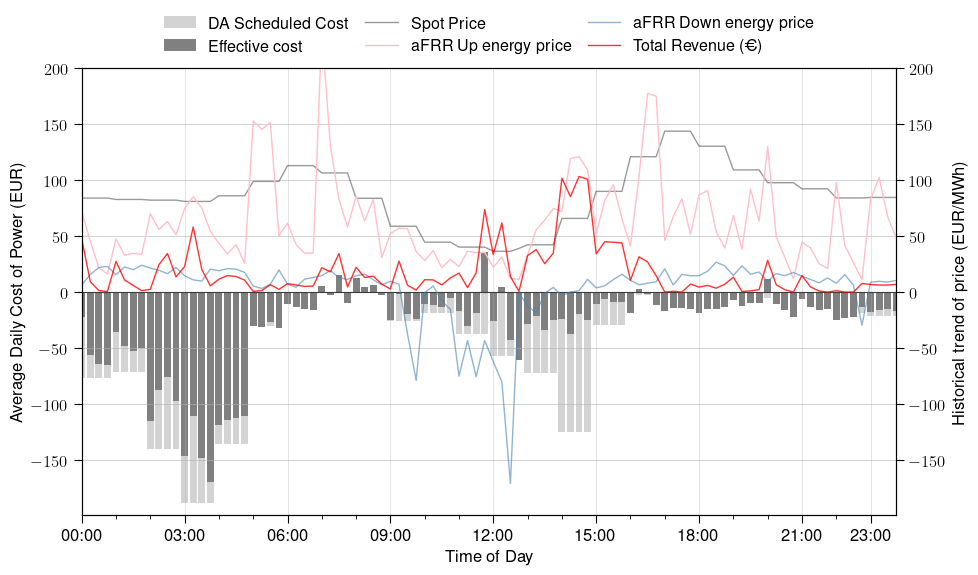

In [23]:
def plot_revenue_spotprice_mean(df, afrr):
    df = df.copy()
    df['MTU Revenue'] = df['MTU Revenue'].clip(upper=500)
    df['Up Revenue'] = df['MTU Revenue'].where(df['direction'] == 1, 0)
    df['Down Revenue'] = df['MTU Revenue'].where(df['direction'] == -1, 0)
    df['Cost'] = df['SpotPriceEUR'] * df['L11 EK plan [MW]'] * 0.25
    df['new cost'] = df['SpotPriceEUR'] * df['Power Boiler (MW)'] * 0.25
    df['eff cost'] = df['new cost'] - df['Up Revenue'] - df['Down Revenue']
    df['Time'] = df['UTC'].dt.strftime('%H:%M')

    mean_profile = df.groupby('Time')[['MTU Revenue','Up Revenue', 'Down Revenue', 'Cost', 'eff cost', 'SpotPriceEUR']].mean()

    # mean profile of afrr prices
    afrr = afrr.groupby('UTC', as_index=False)[['aFRR_DownActivatedPriceEUR_actual', 'aFRR_UpActivatedPriceEUR_actual']].mean()
    afrr['Time'] = afrr['UTC'].dt.strftime('%H:%M')
    mean_profile['aFRR Up Price'] = afrr.groupby('Time')[['aFRR_UpActivatedPriceEUR_actual']].mean()
    mean_profile['aFRR Down Price'] = afrr.groupby('Time')[['aFRR_DownActivatedPriceEUR_actual']].mean()

    absolute_drop = df['Cost'].sum() - df['eff cost'].sum()
    print(f"Total cost: {df['Cost'].sum():.2f} EUR")
    print(f"Total effective cost: {df['eff cost'].sum():.2f} EUR")
    print(f"Absolute drop in cost: {absolute_drop:.2f} EUR")
    relative_drop_percentage = ((df['Cost'].sum() - df['eff cost'].sum()) / df['Cost'].sum()) * 100
    print(f"Relative drop in cost: {relative_drop_percentage:.2f}%")

    plt.figure(figsize=(10, 6))
    # plt.plot(mean_profile.index, mean_profile['Up Revenue'], label='Up Revenue', alpha = 0.8, color='maroon', linewidth=1)
    # plt.plot(mean_profile.index, mean_profile['Down Revenue'], label='Down Revenue', alpha = 0.8, color='blue', linewidth=1)
    plt.axhline(0, color='black', linewidth=0.8)

    plt.bar(mean_profile.index, -mean_profile['Cost'], label='DA Scheduled Cost', color='lightgrey', linewidth=1)
    plt.bar(mean_profile.index, -mean_profile['eff cost'], label='Effective cost', color = 'grey', linewidth=1)
    ax = plt.gca()
    ax2 = plt.gca().twinx()
    ax2.plot(mean_profile.index, mean_profile['SpotPriceEUR'], label='Spot Price', alpha = 0.4, color='black', linewidth=1)
    # avg up down afrr price
    ax2.plot(mean_profile.index, mean_profile['aFRR Up Price'], label='aFRR Up energy price', color='pink', linewidth=1)
    ax2.plot(mean_profile.index, mean_profile['aFRR Down Price'], label='aFRR Down energy price', alpha = 0.6, color='steelblue', linewidth=1)

    plt.plot(mean_profile.index, mean_profile['MTU Revenue'], label='Total Revenue (€)', alpha = 0.8, color='red', linewidth=1)

    plt.xticks(ticks=[f"{h:02d}:00" for h in range(0, 24, 3)] + ["23:00"])
    plt.xlim(mean_profile.index.min(), mean_profile.index.max())
    
    ax.set_xticks(mean_profile.index[::4], minor=True)
    ax.spines['top'].set_visible(True)    
    ax.spines['right'].set_visible(True) 

    ax.set_xlabel('Time of Day')
    ax.set_ylabel('Average Daily Cost of Power (EUR)')
    ax2.set_ylabel('Historical trend of price (EUR/MWh)')

    cost_ylim = ax.get_ylim()
    price_ylim = ax2.get_ylim()

    # Find maximum range around zero
    min_common = min(cost_ylim[0], price_ylim[0])
    max_common = max(cost_ylim[1], price_ylim[1])

    # Set both y-limits symmetrically around 0 if appropriate
    ax.set_ylim(min_common, 200)
    ax2.set_ylim(min_common, 200)
    
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    all_lines = lines1 + lines2
    all_labels = labels1 + labels2
    ax.legend(all_lines,all_labels,loc='upper center',ncol=3,bbox_to_anchor=(0.5, 1.15),fancybox=False,fontsize='small',frameon=False,columnspacing=1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_folder + 'average_cost_profile_MA_march_new.pdf', format='pdf', bbox_inches='tight', dpi=320)
    plt.show()

# plt.rcParams.update({
#             'figure.dpi': '100' # Default DPI value
#     })
plot_revenue_spotprice_mean(df_15m, df[['UTC','aFRR_DownActivatedPriceEUR_actual', 'aFRR_UpActivatedPriceEUR_actual']])

In [24]:
df.columns

Index(['Objective Value', 'Deviation', 'Total Revenue', 'Bid Up (MW)',
       'Bid Down (MW)', 'Power Boiler (MW)', 'Energy Up Cleared (MWh)',
       'Energy Down Cleared (MWh)', 'System SoE (%)', 'System State (MWh)',
       'bid_state', 'activation', 'cleared_status', 'SecondUTC',
       'aFRR_DownActivatedPriceEUR_actual', 'aFRR_UpActivatedPriceEUR_actual',
       'SpotPriceEUR', 'aFRR_UpActivatedPriceEUR',
       'aFRR_DownActivatedPriceEUR', 'UTC', 'Heat load forecast [MW]',
       'L11 EK plan [MW]', 'Capacity Bid', 'Capacity bid direction',
       'actual_bid_outcome', 'Actual Energy Up Cleared (MWh)',
       'Actual Energy Down Cleared (MWh)', 'Actual System SoE (%)',
       'Actual Realised Revenue', 'MTU Revenue', 'direction',
       'Total Energy Up (MWh)', 'Total Energy Down (MWh)'],
      dtype='object')

In [26]:
print('Count of bids placed every 4s')
print(df[(df['direction'] != 0)].shape[0])
print('Count of bids accepted every 4s')
print((df[(df['actual_bid_outcome'] == 1)].shape[0]))

Count of bids placed every 4s
121275
Count of bids accepted every 4s
88396


In [28]:
121275/(15*15)

539.0

In [29]:
df[df['direction'] != 0]['UTC'].nunique()

539

In [8]:
folder_path = "D:\\ms\\January 2024\\Thesis\\Boiler-Bidding-model\\Simulation Output\\"

# df = pd.read_csv(folder_path + 'output_01 to_14_03_recurrsive15m_W50.csv') # ieee paper file
# df = pd.read_csv(folder_path + 'recursive_MARCH_2_to_16_w30_6h_actual_prices_all_constraints.csv') # march report file
df_org = pd.read_csv(folder_path + 'recursive_MARCH_2_to_16_w30_6h_actual_prices_all_constraints.csv') # march report file

df_org['UTC'] =  pd.to_datetime(df_org['UTC'])
df_org['SecondUTC'] =  pd.to_datetime(df_org['SecondUTC'])

# to fix a logical error in recursive_MARCH_2_to_16_w30_6h_actual_prices_all_constraints.csv file
df_org.loc[(df_org['UTC'].dt.floor('h') >= pd.Timestamp('2025-03-06 11:00:00')) & (df_org['UTC'].dt.floor('h') <= pd.Timestamp('2025-03-06 11:15:00')), 'Capacity Bid']= 0
df_org.loc[df_org['Capacity Bid'] > 0, 'activation'] = 1
df_org['direction'] = np.where(
        (df_org['activation'] == 1) & (df_org['Bid Up (MW)'] > 0), 1, 
        np.where(
            (df_org['activation'] == 0) & (df_org['Bid Down (MW)'] > 0), -1, 
        np.where(
            (df_org['Bid Up (MW)'] == 0) & (df_org['Bid Down (MW)'] == 0), 0, np.nan
        )))
df_org['direction'] = df_org['direction'].fillna(0)
energy_agg = df_org.groupby('UTC')[['Energy Up Cleared (MWh)', 'Energy Down Cleared (MWh)']].sum().rename(
                                                                                                        columns={'Energy Up Cleared (MWh)': 'Total Energy Up (MWh)',
                                                                                                                    'Energy Down Cleared (MWh)': 'Total Energy Down (MWh)'})
df_org = df_org.merge(energy_agg, on='UTC', how='left')

In [9]:
# remove afrr price spikes from data 
# df['aFRR_DownActivatedPriceEUR'] = df['aFRR_DownActivatedPriceEUR'].clip(lower=-200)
# df['aFRR_UpActivatedPriceEUR'] = df['aFRR_UpActivatedPriceEUR'].clip(upper=200)
df_org['MTU Revenue Row'] = (
            df_org['Energy Up Cleared (MWh)'] * (df_org['aFRR_UpActivatedPriceEUR']) +
            df_org['Energy Down Cleared (MWh)'] * -df_org['aFRR_DownActivatedPriceEUR'])

mtu_revenue_per_utc_org = df_org.groupby('UTC')['MTU Revenue Row'].sum()
df_org['MTU Revenue'] = df_org['UTC'].map(mtu_revenue_per_utc_org)
df_org.drop(columns=['MTU Revenue Row'], inplace=True)

In [10]:
up_eur = df_org.loc[df_org['direction'] == 1, 'MTU Revenue'].unique().sum()
# rev_up_peaks = df.loc[(df['aFRR_UpActivatedPriceEUR'] > 1000) & (df['direction'] == 1), 'MTU Revenue'].unique().sum()

up_mwh = df_org.loc[df_org['direction'] == 1, 'Energy Up Cleared (MWh)'].sum()
# mwh_up_peaks = df.loc[(df['aFRR_UpActivatedPriceEUR'] > 1000) & (df['direction'] == 1), 'Energy Up Cleared (MWh)'].sum()

down_eur = df_org.loc[df_org['direction'] == -1, 'MTU Revenue'].unique().sum()
# rev_down_peaks = df.loc[(df['aFRR_DownActivatedPriceEUR'] < -1000) & (df['direction'] == -1), 'MTU Revenue'].unique().sum()

down_mwh = df_org.loc[df_org['direction'] == -1, 'Energy Down Cleared (MWh)'].sum()
# mwh_down_peaks = df.loc[(df['aFRR_DownActivatedPriceEUR'] < -1000) & (df['direction'] == -1), 'Energy Down Cleared (MWh)'].sum()

print("Up EUR: ", up_eur)
# print("Up EUR w/o peaks: ", up_eur - rev_up_peaks)

print("Up MWh: ", up_mwh)
# print("Up MWh w/o peaks: ", up_mwh - mwh_up_peaks)

print("Down EUR: ", down_eur)
# print("Down EUR w/o peaks: ", down_eur - rev_down_peaks)

print("Down MWh: ", down_mwh)
# print("Down MWh w/o peaks: ", down_mwh - mwh_down_peaks)

print("Total EUR: ", up_eur + down_eur)
print('output', df_org['Total Revenue'].unique().sum())

Up EUR:  52723.544686813766
Up MWh:  195.5501924130309
Down EUR:  10343.558946790397
Down MWh:  168.5027767115905
Total EUR:  63067.103633604165
output 1440657.7079668215


In [ ]:
df_MArev = df.groupby('UTC', as_index=False).first()[['UTC', 'MTU Revenue']]
df_BASErev = df_org.groupby('UTC', as_index=False).first()[['UTC', 'MTU Revenue']]
df_merged = pd.merge(df_MArev, df_BASErev, on='UTC', how='inner', suffixes=('_MA', '_BASE'))
df_merged['Cumulative_MA'] = df_merged['MTU Revenue_MA'].cumsum()
df_merged['Cumulative_BASE'] = df_merged['MTU Revenue_BASE'].cumsum()


In [44]:
df_merged['UTC'] = df_merged['UTC'] - pd.Timedelta(days=1)

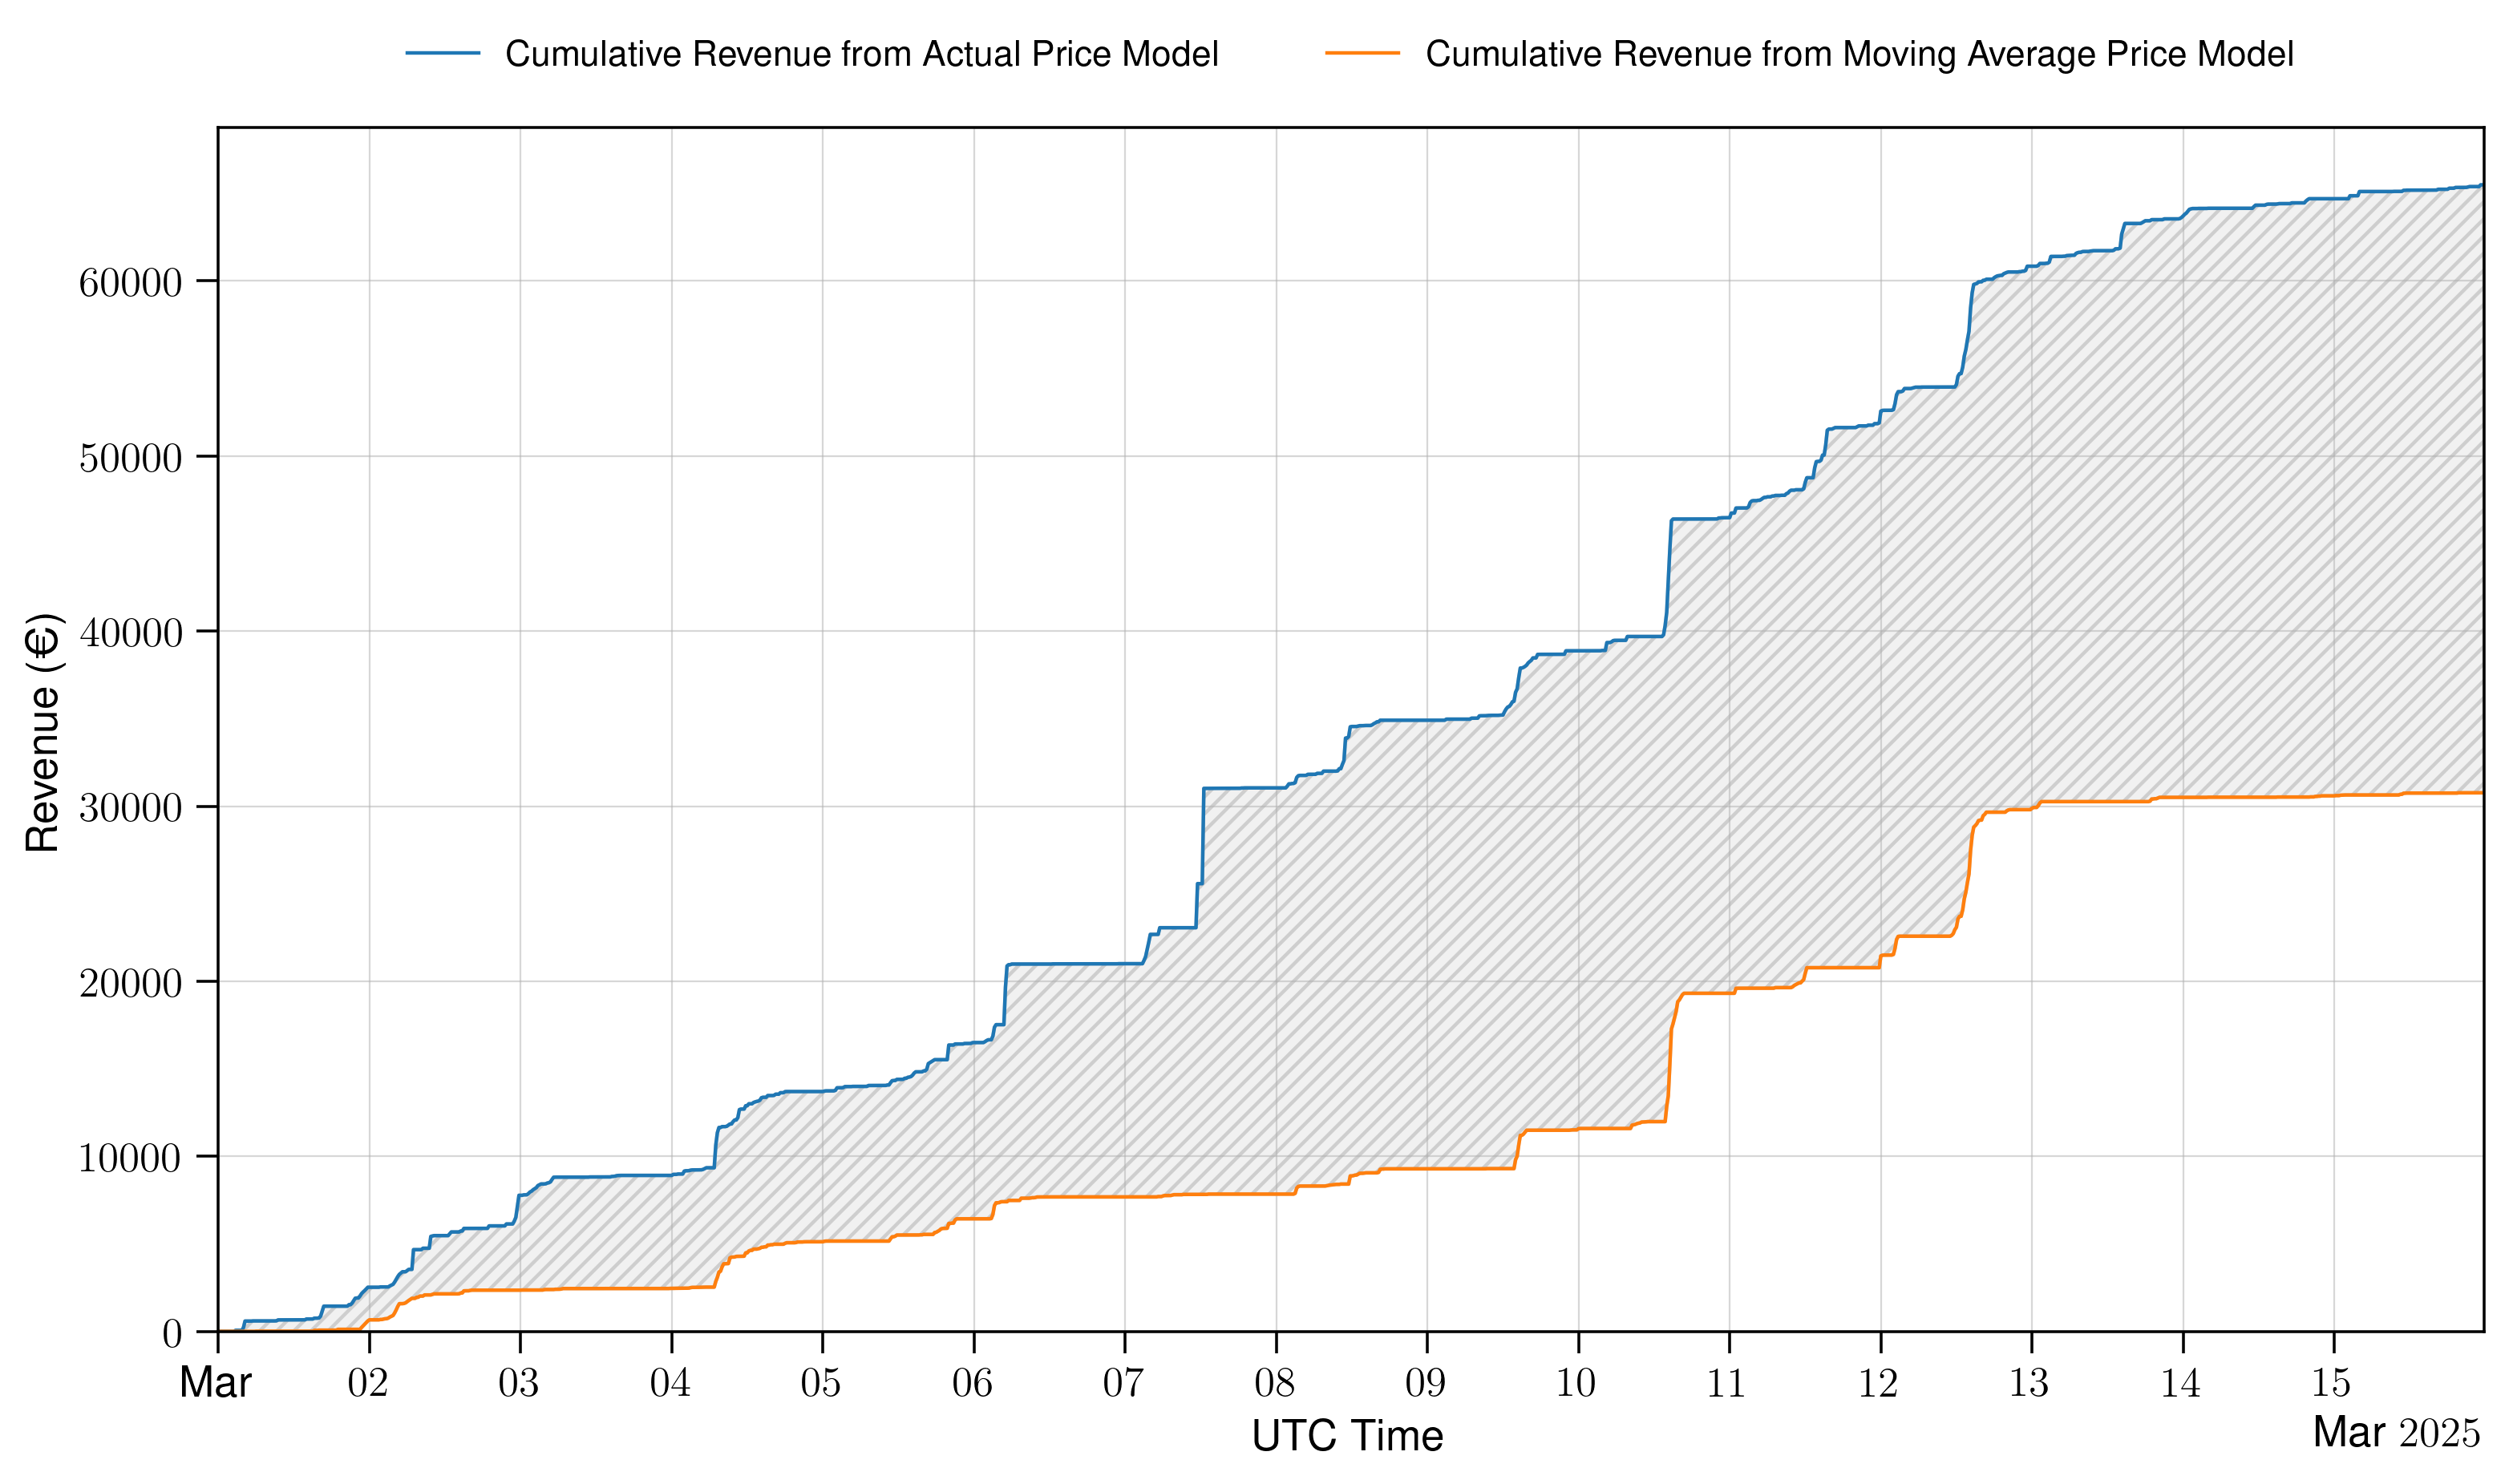

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the two cumulative revenue curves
ax.plot(df_merged['UTC'], df_merged['Cumulative_BASE'],
        label='Cumulative Revenue from Actual Price Model', linewidth=1)
ax.plot(df_merged['UTC'], df_merged['Cumulative_MA'],
        label='Cumulative Revenue from Moving Average Price Model', linewidth=1)

# Fill where MA is lower than BASE
ax.fill_between(df_merged['UTC'],df_merged['Cumulative_MA'],df_merged['Cumulative_BASE'],where=(df_merged['Cumulative_MA'] < df_merged['Cumulative_BASE']),facecolor='lightgrey',hatch='/////',edgecolor='grey',alpha=0.3,interpolate=True)

# Labels and styling
ax.set_xlabel('UTC Time')
ax.set_ylabel('Revenue (€)')
ax.legend(loc='upper center',ncol=3,bbox_to_anchor=(0.5, 1.1),fancybox=False,fontsize=10,frameon=False,columnspacing=3)
ax.grid(True)
ax.set_xlim(df_merged['UTC'].min(), df_merged['UTC'].max())
ax.set_ylim(0)

# Format x-axis with 6-hour ticks and concise date formatting
locator = mdates.DayLocator(interval=1)
formatter = mdates.ConciseDateFormatter(locator)
formatter.offset_formats = ['', '%Y', '%b %Y', '%b %Y', '%b %Y', '%b %Y']
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig(output_folder + 'willingness_to_pay.pdf', format='pdf', bbox_inches='tight', dpi=320)

plt.show()